# Project 3 - Behavioral Cloning - Data Analysis & Exploration

### Settings

In [1]:
import numpy as np

# set random seed
np.random.seed(256)

import utils
from dataloader import DataLoader

def get_image(settings, image_name):
    file_name = utils.get_image_file_name(image_name)
    return utils.load_image(settings.data_path + settings.images_path + file_name.strip())

import matplotlib.pyplot as plt
%matplotlib inline
# plot a list of images in a single row
def plot_images_in_a_row(images, titles):
    cols = len(images)
    rows = 1
    fig = plt.figure(figsize=(cols * 4, rows * 4))

    for i in range(cols):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])

    plt.show()
    
from settings import Settings
default_settings = Settings(
    data_path = 'data/',
    data_file = 'driving_log.csv',
    images_path = 'IMG/',
    batch_size = 512, 
    epochs = 10,
    learning_rate = 0.001,
    epoch_sample_size = 25000
)

# print settings
print(default_settings)

SETTINGS
data_path: data/
data_file: driving_log.csv
images_path: IMG/
batch_size: 512
epochs: 10
learning_rate: 0.001
epoch_sample_size: 25000
samples per epoch: 25088



### Data Loading

In [2]:
print("Loading data ...")
dataloader = DataLoader(default_settings)
data = dataloader.get_csv_data()
print("Number of entries : ", len(data))
print("Done.")

Loading data ...
Number of entries :  8036
Done.


### View Data Contents

In [3]:
data.iloc[:5]

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


#### Key Findings
* Each of the data has left, right and center camera angle images, with only one steering angle for the center camera
* To utlize left & right camera images, steering data needs to be augmented

### Summarize Numerical Data

In [4]:
data.describe()

,steering,throttle,brake,speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183093
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


#### Key Findings
* Steering range : -1.0 to 1.0
* Throttle was high during most of the recorded run (0.9855)
* Brake was rarely used during the recording (0 @ 75%)
* Speed was at the maximum during the recording (30.18 @ 75%)

### Visualize the distribution of 'Streering' column data

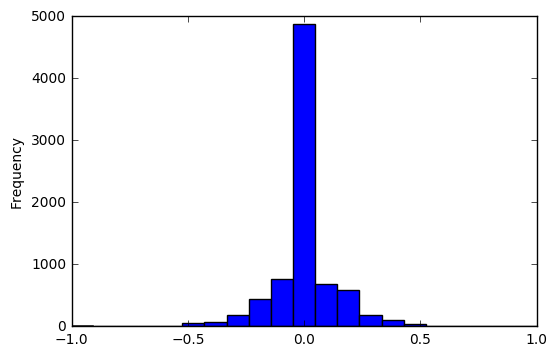

In [5]:
# plot the distribution of steering angles
data['steering'].plot.hist(range=(-1,1), bins=21)

#### Key Findings
* Most of the sterring angle is 0, recorded with mostly driving on the center of the lane
* Almost all of the steering angles are between -0.5 to 0.5, clearly indicates not much of sharp turns in the track, especially when the recording was done at full speed of the vehicle.

In [6]:
# get values of left, center, right images and steering angles
center = [utils.get_image_file_name(file_path) for file_path in data['center'].values] 
left = [utils.get_image_file_name(file_path) for file_path in data['left'].values] 
right = [utils.get_image_file_name(file_path) for file_path in data['right'].values] 
steering = data['steering'].values

# select sample images for data exploration
samples = [1500, 100, 2750]

# load images
center_sample_images = [get_image(default_settings, center[index]) for index in samples]
left_sample_images = [get_image(default_settings, left[index]) for index in samples]
right_sample_images = [get_image(default_settings, right[index]) for index in samples]
print("Input image shape : ", center_sample_images[0].shape)

Input image shape :  (160, 320, 3)


### Visualize an image

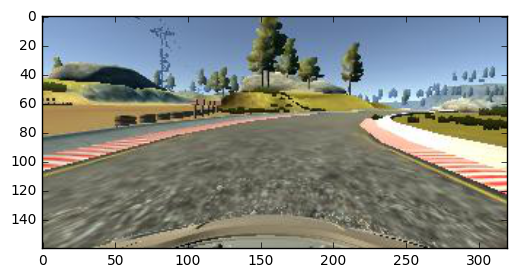

In [7]:
# display image
plt.imshow(center_sample_images[0])
plt.show()

#### Key Findings
* Top 70 pixels and bottom 24 pixels could be cropped to reduce sky, tree and hood of the car.
* Left 60 pixels and right 60 pixels could be cropped to make it 66x200 pixels input for NVIDIA model

### Visualize images (left, center, right)

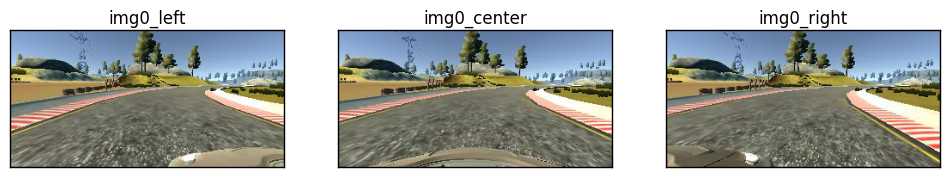

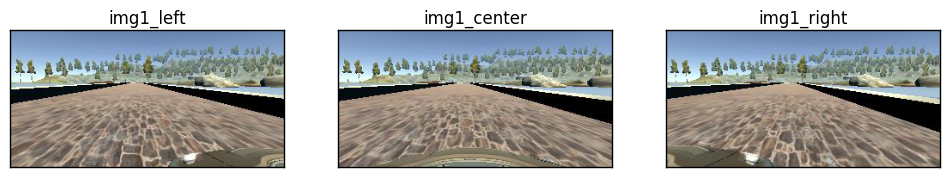

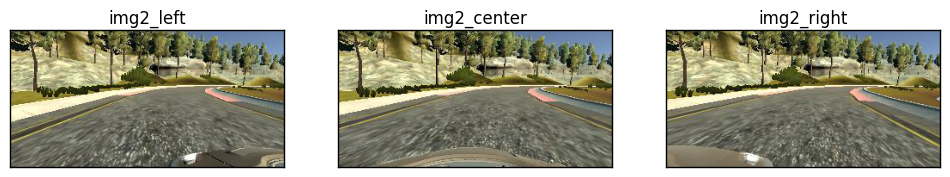

In [8]:
for i in range(len(samples)):
    samples_title = ["img{}_{}".format(i, 'left'), "img{}_{}".format(i, 'center'), "img{}_{}".format(i, 'right')]
    plot_images_in_a_row([left_sample_images[i], center_sample_images[i], right_sample_images[i]], samples_title)

### Crop Images

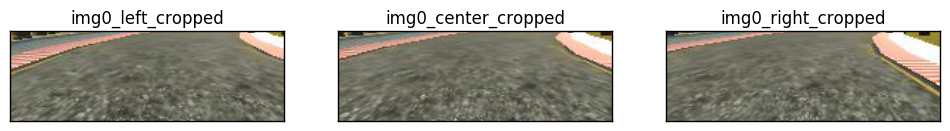

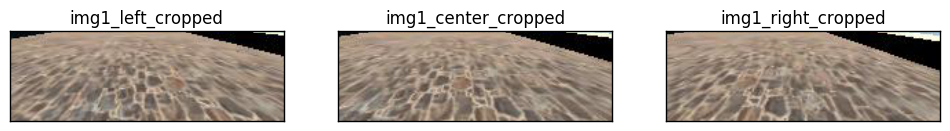

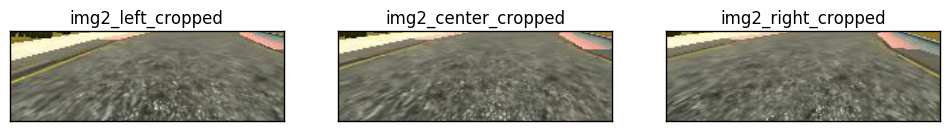

Original image shape :  (160, 320, 3)
Cropped image shape :  (66, 200, 3)


In [9]:
cropped_left_images = [utils.crop_image(image) for image in left_sample_images]
cropped_center_images = [utils.crop_image(image) for image in center_sample_images]
cropped_right_images = [utils.crop_image(image) for image in right_sample_images]

for i in range(len(samples)):
    samples_title = ["img{}_{}_cropped".format(i, 'left'), "img{}_{}_cropped".format(i, 'center'), "img{}_{}_cropped".format(i, 'right')]
    plot_images_in_a_row([cropped_left_images[i], cropped_center_images[i], cropped_right_images[i]], samples_title)
    
print("Original image shape : ", center_sample_images[0].shape)
print("Cropped image shape : ", cropped_center_images[0].shape)

### Combining left and right camera images with adjusted steering angle (+/- 0.20)

X (number of samples) : 24108


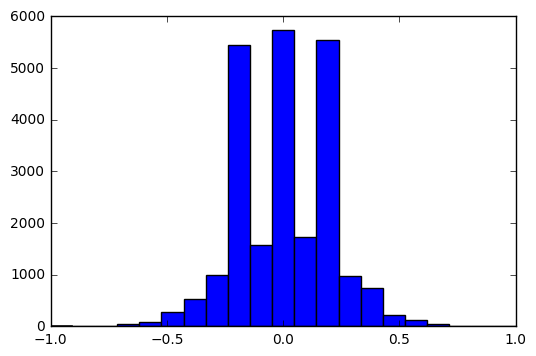

In [10]:
X, y = dataloader.get_data(correction=0.2)
plt.hist(y, range=(-1,1), bins=21)
plt.show()

#### Key Findings
* As we added left and right camera images with adjusted steering angle (+/- 0.20), we could confirm the spike in -0.2 and 0.2 steering angle bins, since most of the samples had steering angle 0.0

### Random Effects

Following are the list of image processing effects randomly added to augment our data, for the training of our model. Appropriate adjustments to steering angle done as well.

#### Flipping

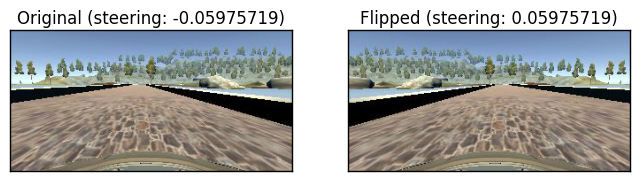

In [11]:
image_input = get_image(default_settings, center[100])
steering_angle = steering[100]
image_flipped = utils.flip_image(image_input)
plot_images_in_a_row([image_input, image_flipped],["Original (steering: {})".format(steering_angle), "Flipped (steering: {})".format(steering_angle * -1)])

#### Brightness Adjustment

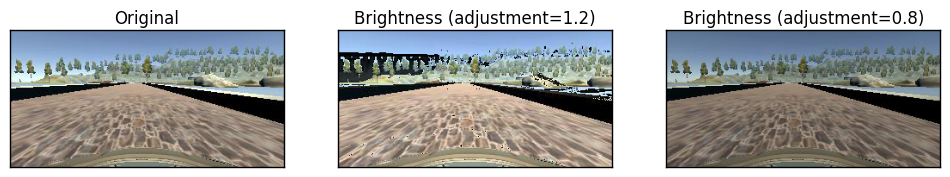

In [12]:
image_brightness_adjusted1 = utils.adjust_brightness(image_input, 1.2)
image_brightness_adjusted2 = utils.adjust_brightness(image_input, 0.8)
plot_images_in_a_row([image_input, image_brightness_adjusted1, image_brightness_adjusted2], ['Original', "Brightness (adjustment=1.2)", "Brightness (adjustment=0.8)"])

#### Gamma Adjustment

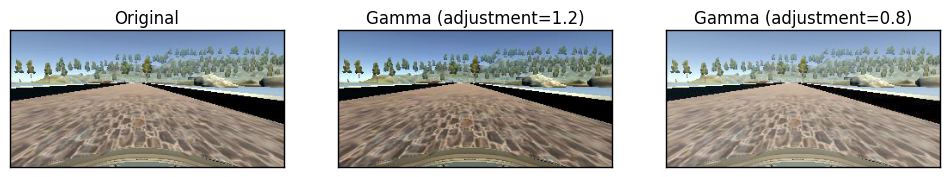

In [13]:
from skimage.exposure import adjust_gamma
image_gamma_adjusted1 = adjust_gamma(image_input, gamma=1.2)
image_gamma_adjusted2 = adjust_gamma(image_input, gamma=0.8)
plot_images_in_a_row([image_input, image_gamma_adjusted1,image_gamma_adjusted2], ['Original', "Gamma (adjustment=1.2)", "Gamma (adjustment=0.8)"])

#### Translation

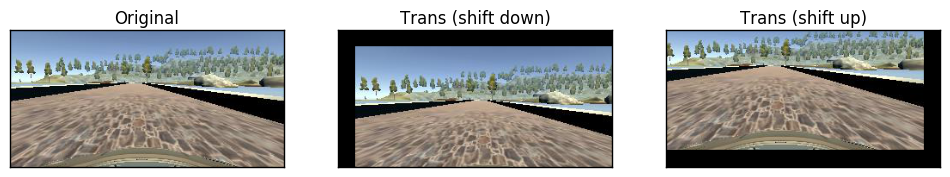

In [14]:
image_translated1 = utils.translate_image(image_input, x_trans=20, y_trans=0.5)
image_translated2 = utils.translate_image(image_input, x_trans=-20, y_trans=-0.5)
plot_images_in_a_row([image_input, image_translated1,image_translated2],['Original', "Trans (shift down)", "Trans (shift up)"])

#### Shadow

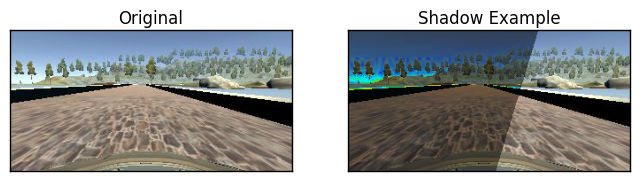

In [20]:
image_shadowed1 = utils.random_shadow(image_input)
plot_images_in_a_row([image_input, image_shadowed1],['Original', "Shadow Example"])

### Recovery Training

In order for the model to be robust, data was collected simulating the situation of recovering from left and right edges of the lane. Example below shows the recovery training.


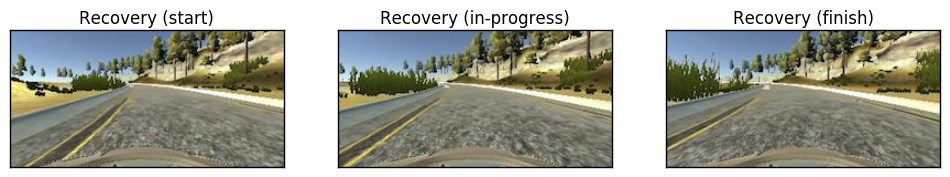

In [21]:
recovery_files = ['./output/recover1.jpg','./output/recover2.jpg', './output/recover3.jpg']
recovery_images = [utils.load_image(file) for file in recovery_files]
plot_images_in_a_row(recovery_images,['Recovery (start)', 'Recovery (in-progress)', 'Recovery (finish)'])